# Predicting flu incidence from Wikipedia

The goal of this project is to reproduce for Italy the results reported in this article for the USA:

	[1] D.J. McIver & J. S. Brownstein (2014), "Wikipedia Usage Estimates Prevalence of Influenza-Like Illness in the United States in Near Real-Time", PLoS Comput Biol 10(4): e1003581	http://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1003581

## The Data

### OFFICIAL DATA ON INFLUENZA IN ITALY
The Italian health protection agency runs a flu surveillance program called "Influnet" that uses sentinel doctors.
The project is described here: http://www.iss.it/iflu/index.php?lang=1&anno=2016&tipo=4

We have one file for every flu season.
We only need the 1st nd 5th columns of each file that are, respectively, the week of the year https://en.wikipedia.org/wiki/ISO_week_date) and the estimated flu incidence for that week (i.e., fraction in the population
of new weekly cases).
These data will be out ground truth and are stored in the *influnet* folder.

### WIKIPEDIA PAGE VIEW DATA

Wikimedia Foundation makes available several datasets, tools and APIs to work with page view data. A summary can be found here:
	https://en.wikipedia.org/wiki/Wikipedia:Pageview_statistics.
    
For this project, we will use third-party tools -	http://bit.ly/2g0vPoA -	that does most of the work for you and allow you to download weeekly pageview data in CSV for the pages you choose and are stored in the *wiki* folder.

## Part 1

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import numpy as np
import numpy as np
import random
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

%matplotlib inline

## 1.1 Importing Influnet data

In [165]:
# Data preprocessing:

# the years I am interested in:
years = map(str,range(2007,2017,1))

# the name of the columns of the dataframe 
columns =['week','incidence']
# an empyùty dataframe in which I will keep the Influnet data
influnet = pd.DataFrame(columns=columns)

# for every couple of year from 2008-2009 to 2015-2016 
# open the csv file into the influnet dataframe
for i in range(len(years)-1):    
    df= pd.read_csv("influnet/data/influnet_"+years[i]+"-"+years[i+1]+".txt", sep='\s',  header=None, skiprows=1, usecols=[0,4], names=['week','incidence'], engine='python')
    
    # clean the data: some files use the comma for decimal numbers
    if type(df['incidence'][0]) is str:
        df['incidence'] = df['incidence'].str.replace(',','.')

    influnet = influnet.append(df, ignore_index=True)

# get the year 
influnet['year'] = [int(influnet.week[i].split('-')[0]) for i in range(len(influnet))]
# get the week
influnet['week_num'] = [int(influnet.week[i].split('-')[1]) for i in range(len(influnet))]

# set a multiindex composed by: 
# (year,week)
influnet = influnet.set_index(['year','week_num'])['incidence']

# the values of influnet are string, set them to float:
for (y,w) in influnet.index:
        influnet.loc[(y,w)] = float(influnet.loc[(y,w)])
        
influnet.head()

year  week_num
2007  42          0.19
      43          0.32
      44          0.26
      45          0.41
      46          0.51
Name: incidence, dtype: object

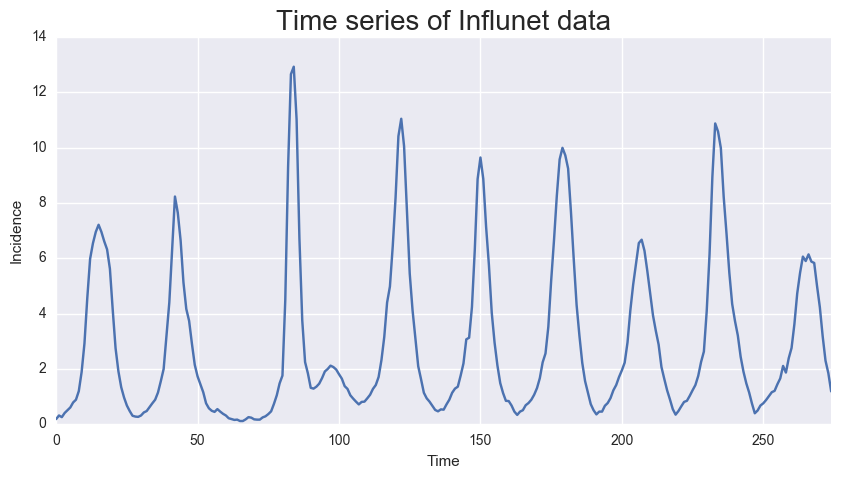

In [170]:
# plot the influnet dataframe
influnet.plot(figsize=(10,5), use_index=False)
plt.xlabel('Time')
plt.ylabel('Incidence')
plt.title('Time series of Influnet data', fontsize=20)

From this plot we can see that there is a peak that corresponds to the H1N1 pandemic of 2009. In fact the peak is located between the twelfth week of 2009 and the ninth week of 2010. This year hence is an outlier.

In [164]:
influnet.index[50],influnet.index[100]

((2009, 12), (2010, 9))

## Part 2: Comparing Wikipedia data with the official ones

I chose the following pages:

In [182]:
pages=['influenza', 'febbre','vomito', 'rinorrea', 'mialgia', 'vaccino_antinfluenzale','paracetamolo', 'brivido', 
       'tampone_faringeo', 'oseltamivir',  'pagina_principale']

For each one of them I have downloaded from Wikishark the csv file that stores, for every hour, the number of visit to its Wikipedia page.

In [183]:
# open the file and store them in the datafram w_hour
# which contains the number of visit for every page per hour
w_hour = pd.read_csv('wikishark_'+pages[0]+'.csv', parse_dates=[0], usecols=range(2), names=['Date',pages[0]], skiprows=1,sep=',')

for page in pages[1:len(pages)]:
    w_hour[page] = pd.read_csv('wikishark_'+page+'.csv', parse_dates=[0], usecols=range(2), names=['Date',page], skiprows=1)[page]

# get the year from the parsed Date column
w_hour['year'] = w_hour.Date.dt.year
# and the number of the week in the Isocalendar
w_hour['week_num'] = [w_hour.Date[i].isocalendar()[1] for i in range(len(w_hour))]
w_hour['hour']  = w_hour.Date.dt.hour
w_hour.ix[0]

Date                      2008-01-01 00:00:00
influenza                                   3
febbre                                      3
vomito                                      1
rinorrea                                    0
mialgia                                     3
vaccino_antinfluenzale                      0
paracetamolo                                7
brivido                                     0
tampone_faringeo                            0
oseltamivir                                 0
pagina_principale                       16678
year                                     2008
week_num                                    1
hour                                        0
Name: 0, dtype: object

On aggregating the hourly pageview data to compute weekly pageviews, we will not consider those hours that correspond to night time in Italy. In particular we will keep only the hours between 9 am to 11 pm.

Furthermore, we will not include in our experiment the ear 2009, since - as stated above - it is an outlier for this phenomenon.

In [184]:
# the daily hours
daily_hours = range(9,23,1)

# exclude 2009
w_hour=w_hour.loc[~w_hour['year'].isin([2009])]

# groupby year and week and sum on the columns, keeping only the columns that corresponds to the wikipedia pages
wiki_week = w_hour[w_hour.hour.isin(daily_hours)].groupby(['year','week_num']).sum()[pages]
wiki_week.head()

influenza  febbre  vomito  rinorrea  mialgia  \
year week_num                                                 
2008 1              1243  3236.0   740.0     132.0   3236.0   
     2               843  2250.0   523.0     121.0   2250.0   
     3               930  1996.0   554.0     117.0   1996.0   
     4               883  2202.0   450.0     119.0   2202.0   
     5               945  2113.0   524.0      96.0   2113.0   

               vaccino_antinfluenzale  paracetamolo  brivido  \
year week_num                                                  
2008 1                            0.0        3491.0    148.0   
     2                            0.0        2300.0     95.0   
     3                            0.0        2146.0    129.0   
     4                            0.0        2214.0    109.0   
     5                            0.0        1951.0     95.0   

               tampone_faringeo  oseltamivir  pagina_principale  
year week_num                                                    
2008 1                      0.0        130.0          3897968.0  
     2                     34.0        123.0          3169418.0  
     3                     42.0        104.0          3117533.0  
     4                     50.0        387.0          3219009.0  
     5                     67.0        138.0          3203449.0

In order to compute the correlation and to fit a model, I compute the weeks that the two dataset *influnet* and *wiki_week* have in common. I will discard the rest.

In [185]:
# idx is the intersection of the two indexes of wiki_week and influnet
# it will store all the couple (year,week) for which we have an observation both of the Wikipedia dataset
# and the official Influnet dataset
idx = wiki_week.index.intersection(list(influnet.index))
# I will discard all those weeks that the two dataset do not have in common
wiki_week = wiki_week.loc[idx]
influnet = influnet.loc[idx]

# compute the correlation between the time series of the Influnet dataset and all the other pages
# I will not compute the correlation between Influnet data and the entity "pagina_principale", 
# which is the last element of the list "pages", because it represents a global trend.
for page in pages[:-1]:
    print page+': ', np.corrcoef(map(float,influnet), wiki_week[page])[0,1]

influenza:  0.637743812649
febbre:  0.450484848592
vomito:  0.137630724665
rinorrea:  0.306413368506
mialgia:  0.450484848592
vaccino_antinfluenzale:  -0.195503938151
paracetamolo:  0.412908360237
brivido:  0.186435283965
tampone_faringeo:  0.237657823942
oseltamivir:  0.624102686531


"Influenza" page is the most correlated with the official data. Also "Febbre", "Mialgia" and "paracetamolo" have a significant correlation, compared to the others. 
"Vaccino Antinfluenzale" has a negative correlation, this might be because people look for it before the influenza outbreak.

This fact is more evident from the plots:

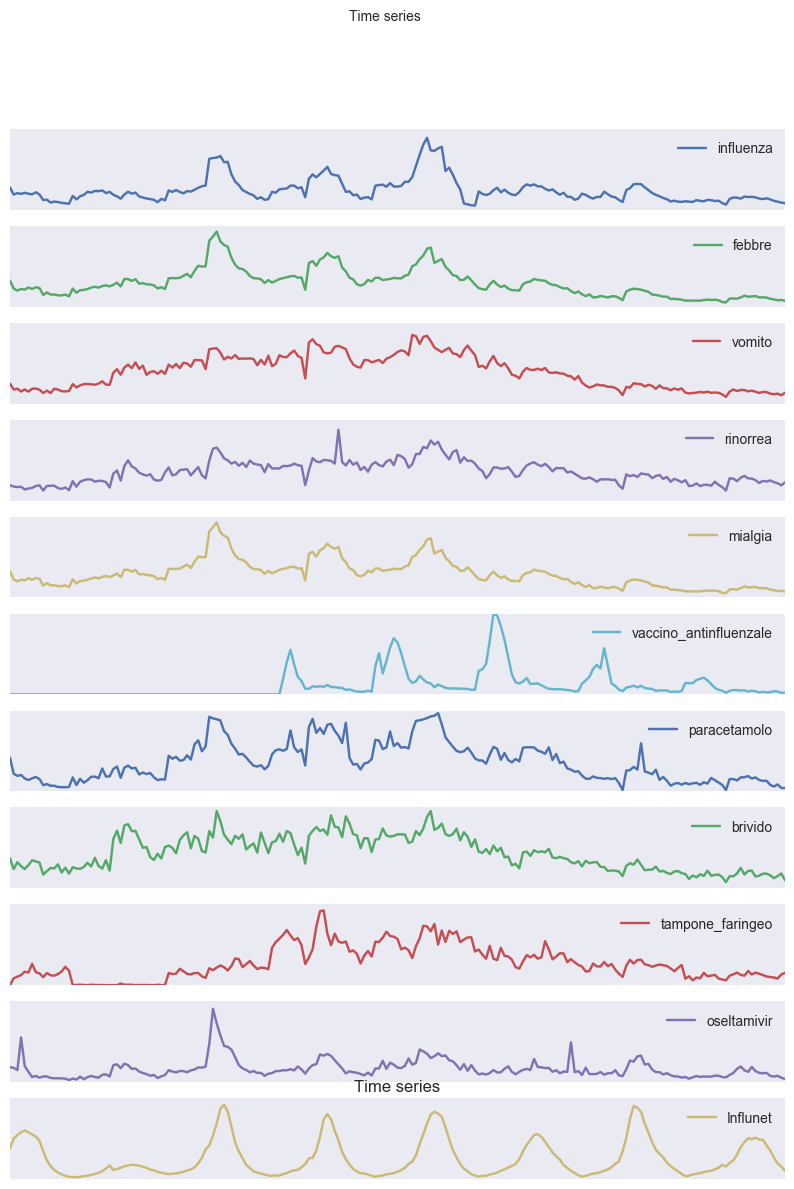

In [187]:
df_for_plotting=wiki_week[pages[:-1]]
df_for_plotting['Influnet']=influnet
p=df_for_plotting.plot(subplots=True,yticks=[],figsize=(10,15), use_index=False,title='Time series')
plt.xticks([])
plt.title('Time series')

In order to compare this time series to the overall traffic on wikipedia, I will devide all the time series of the Wikipedia pages by the weekly number of visits that the "Pagina Principale" of Wikipedia received.

In [189]:
wiki_week = wiki_week.div(wiki_week['pagina_principale'], axis='index')[pages[:-1]]

## Part 3: Model Learning

### 3.1

We build a regression model that predicts the Influnet incidence for a given week based on the Wikipedia pageview data for the same week.
	
The features are the Wikipedia pageview counts for the "Influenza" page, for all the pages we have selected in Part 2.
We evaluate the performance of your model via cross-validation.

I will test three Generalized Linear Models (Linear Regression, Lasso with Cross-Validation and Ridge with Cross-Validation) and a Random Forest Regressor.

I will test the performances of these four models with a cross validation:

I will split 10 times the datafram *wiki_week* in two sets, a validation one and a train one. The validation will be composed of 20 consecutive weeks, all the other weeks will be part of the training set. I will compute the rmse for every iteration, and eventually the mean

In [208]:
folds = [range(20), range(20,40), range(40,60), range(60,80), range(80,100),
        range(100,120),range(120,140),range(140,160),range(160,180),range(180,200)]

In [210]:
# the alphas that LassoCV and RidgeCV want in input in order to perform cross validation on every small train set
alphas=np.arange(0.000001, 0.0001, 0.000001)


rnd_forest_rmse=0
linear_rmse=0
lassoCV_rmse=0
ridgeCV_rmse=0

for i in range(10):
    
    # select the i-th fold, i.e. a time-window on which I validate the model
    # rows is the slice of the index of the dataframe wiki_week I want to tak into account
    # for axample folds[0] gives the week from the 0-th to the 19-th
    rows = folds[i]
    
    # the independent variables of the validation test
    validation_features = wiki_week.ix[rows]
    # all the other weeks are the index corresponding to the training set
    train_features = wiki_week.loc[~wiki_week.index.isin(rows)]
    
    # the dependent variable that the model will predict
    validation_flu_data = influnet.ix[rows]
    # the dependent variable for the training
    train_flu_data = influnet.loc[~influnet.index.isin(rows)]
    
    # LINEAR REGRESSION
    linear_reg = linear_model.LinearRegression()
    linear_reg.fit(train_features, train_flu_data)
    linear_prediction = linear_reg.predict(validation_features)
    linear_rmse += np.sqrt(mean_squared_error(linear_prediction,validation_flu_data))
    
    
    # RANDOM FOREST
    rnd_forest_reg = RandomForestRegressor()
    rnd_forest_reg.fit(train_features, train_flu_data)
    rnd_forest_prediction = rnd_forest_reg.predict(validation_features)
    rnd_forest_rmse += np.sqrt(mean_squared_error(rnd_forest_prediction,validation_flu_data))
    
    
    # LASSO with CV
    lassoCV_reg = linear_model.LassoCV(alphas=alphas)
    lassoCV_reg.fit(train_features, train_flu_data)
    lasso_prediction = lassoCV_reg.predict(validation_features)
    lassoCV_rmse += np.sqrt(mean_squared_error(lasso_prediction,validation_flu_data))
    
    
    # RIDGE with CV
    ridge_reg=linear_model.RidgeCV(alphas=alphas)
    ridge_reg.fit(train_features, train_flu_data)
    ridge_prediction = ridge_reg.predict(validation_features)
    ridgeCV_rmse += np.sqrt(mean_squared_error(ridge_prediction,validation_flu_data))
    
    
print '\n Linear: ', linear_rmse/10.

print '\n Random Forest Regressor: ', rnd_forest_rmse/10.

print '\n Lasso Cross Validation: ', lassoCV_rmse/10.

print '\n Ridge Cross-Validation: ',ridgeCV_rmse/10.


 Linear:  1.15892387085

 Random Forest Regressor:  0.589413889076

 Lasso Cross Validation:  1.27041161788

 Ridge Cross-Validation:  1.26345351928


To get an intuition of how the prediction is performed, let us take a look at the plot that corresponds to the last fold

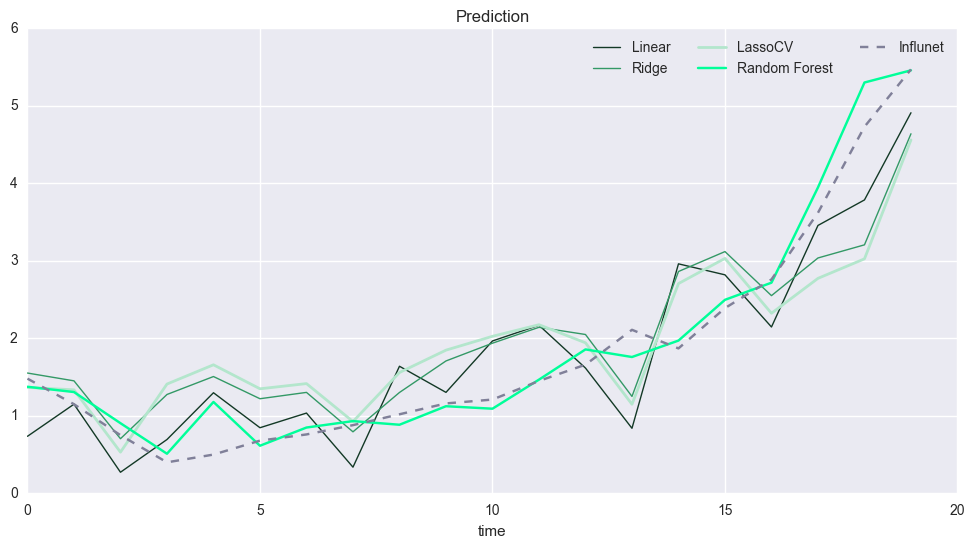

In [215]:
plt.figure(figsize=(12,6))
plt.plot(linear_prediction, color='#133926', linewidth=1)
plt.plot(ridge_prediction, color='#339966', linewidth=1)
plt.plot(lasso_prediction, color='#b3e6cc', linewidth=2)
plt.plot(rnd_forest_prediction, color='#00ff99')
plt.plot(validation_flu_data.as_matrix(),'--', color='#808099')
plt.xlabel('time')
plt.title('Prediction')
plt.legend(['Linear','Ridge','LassoCV','Random Forest','Influnet'],ncol=3)

As we could have expected Lasso and Ridge regressor provide smoother estimate of the real data. Random Forest is the one that performs the best, both in terms of RMSE and smoothness of the prediction.

### 3.2

Now, I will add the following features:
- the pageview count of the previous week for every page in pages=['influenza', 'febbre', 'vomito', 'rinorrea','mialgia','vaccino_antinfluenzale','paracetamolo', 'brivido', 'tampone_faringeo','oseltamivir']
- the Influnet incidence data of the previous week.

To do so I will consider only weeks whose previous week is in the dataset:

In [217]:
weeks_with_previous = []
# for every couple year,week in the index of wiki_week (that is tha same of that of influnet)
for (y,w) in idx:
    # if the previous week is still in the index, append it to the list
    if (y,w-1) in idx:
        weeks_with_previous.append((y,w))

The models are the same I used in the previous point, and once again I will evaluate their performances via cross validation.

In [222]:
folds = [range(28), range(28,56), range(56,84), range(84,112), range(112,140),range(140,168),range(168,196)]

In [235]:
rnd_forest_rmse=0
linear_rmse=0
lassoCV_rmse=0
ridgeCV_rmse=0


for i in range(7):
    
    # select the i-th fold, i.e. a time-window on which I validate the model
    # rows is the slice of the index of the dataframe wiki_week I want to tak into account
    # for axample folds[0] gives the week from the 0-th to the 27-th
    validation_rows = [weeks_with_previous[week_index] for week_index in folds[i]]
    # the feature for the validation set
    validation_features = wiki_week.ix[validation_rows]
    
    
    train_rows = list(set(weeks_with_previous).difference(set(validation_rows)))
    # the features for the train set
    train_features = wiki_week.ix[train_rows]
    
    
    
    # for every couple (year, week), keep the previousk
    validation_precweek = [(year,week-1) for (year,week) in validation_rows]
    # add the feature: influnet data of the previous week
    validation_features['prec_week'] = list(influnet.ix[validation_precweek])
    # add the columns prec_influenza, prec_febbre ecc
    # in the ith row of this column there is the pageview counts int the previousk 
    # of the page influenza, febbre ecc...
    for col in wiki_week.columns:
        validation_features['prec_'+col]=list(wiki_week.ix[validation_precweek][col])    
    
     
    #  Do the same procedure I have done for the validation test
    train_precweek = [(year,week-1) for (year,week) in train_rows]    
    train_features['prec_week'] = list(influnet.ix[train_precweek])
    for col in wiki_week.columns:
        train_features['prec_'+col]=list(wiki_week.ix[train_precweek][col])
        
    
    
    # the dependent variable that the model will predict
    validation_flu_data = influnet.ix[validation_rows]
    # the dependent variable for the training
    train_flu_data = influnet.ix[train_rows]
    
    
    
    # LINEAR REGRESSION
    linear_reg = linear_model.LinearRegression()
    linear_reg.fit(train_features, train_flu_data)
    linear_prediction = linear_reg.predict(validation_features)
    linear_rmse += np.sqrt(mean_squared_error(linear_prediction,validation_flu_data))
    
    
    # RANDOM FOREST
    rnd_forest_reg = RandomForestRegressor()
    rnd_forest_reg.fit(train_features, train_flu_data)
    rnd_forest_prediction = rnd_forest_reg.predict(validation_features)
    rnd_forest_rmse += np.sqrt(mean_squared_error(rnd_forest_prediction,validation_flu_data))
    
    
    # LASSO with CV
    lassoCV_reg = linear_model.LassoCV(alphas=alphas)
    lassoCV_reg.fit(train_features, train_flu_data)
    lasso_prediction = lassoCV_reg.predict(validation_features)
    lassoCV_rmse += np.sqrt(mean_squared_error(lasso_prediction,validation_flu_data))
    
    
    # RIDGE with CV
    ridge_reg=linear_model.RidgeCV(alphas=alphas)
    ridge_reg.fit(train_features, train_flu_data)
    ridge_prediction = ridge_reg.predict(validation_features)
    ridgeCV_rmse += np.sqrt(mean_squared_error(ridge_prediction,validation_flu_data))
    
print '\n Linear: ', linear_rmse/7.

print '\n Random Forest Regressor: ', rnd_forest_rmse/7.

print '\n Lasso Cross Validation: ', lassoCV_rmse/7.

print '\n Ridge Cross-Validation: ',ridgeCV_rmse/7.


 Linear:  0.746578185246

 Random Forest Regressor:  0.849581914079

 Lasso Cross Validation:  0.674552072423

 Ridge Cross-Validation:  0.681630595675


The plots of the prediction made by the four regressor on the last fold:

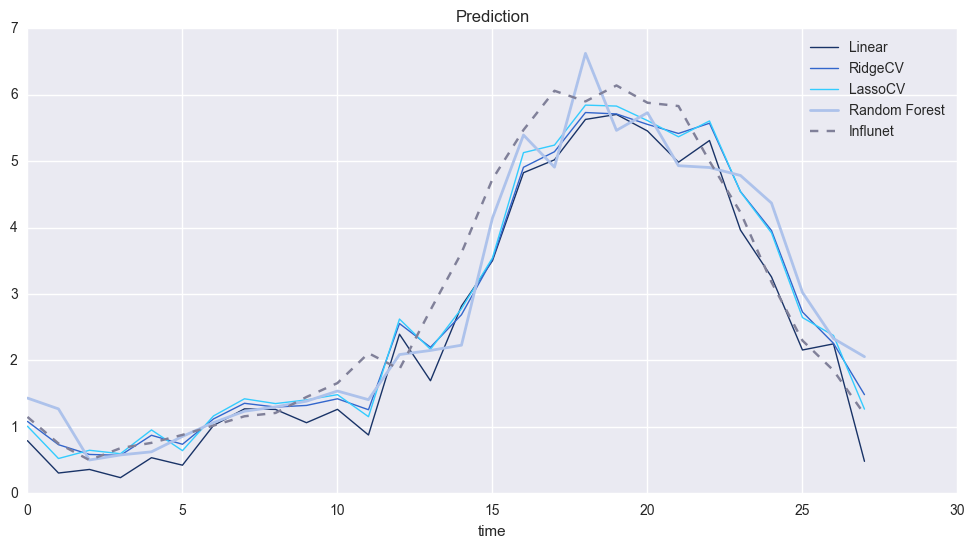

In [240]:
plt.figure(figsize=(12,6))
plt.plot(linear_prediction, color='#193367', linewidth=1)
plt.plot(ridge_prediction, color='#3366cc', linewidth=1)
plt.plot(lasso_prediction, color='#33ccff', linewidth=1)
plt.plot(rnd_forest_prediction, color='#adc2eb', linewidth=2)
plt.plot(validation_flu_data.as_matrix(),'--', color='#808099')
plt.xlabel('time')
plt.title('Prediction')
plt.legend(['Linear','Ridge','LassoCV','Random Forest','Influnet'])
p=plt.legend(['Linear','RidgeCV','LassoCV','Random Forest','Influnet'])

In this case the best predictor in terms od RMSE is the Lasso. This might be because now we have more than doubled the number of features, and Lasso performs both smoothing and feature selection. We can actually see that also the Lasso and the Ridge prediction function are much smoother than the others.